In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from PIL import Image, ImageOps
from tensorflow.keras import layers, Model, regularizers, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Permute, Reshape, Bidirectional, LSTM, Dense

In [3]:
import json

# Open and read the JSON file
with open('images/synthetic_thermometer_images/metadata.json', 'r') as file:
    data = json.load(file)
    
dfs1 = pd.DataFrame(data).rename(columns={'temperature':'reading'}).dropna().sample(frac=0.2, random_state=42).reset_index(drop=True)

# Open and read the JSON file
with open('images/synthetic_thermometer_images (temp-dual)/metadata.json', 'r') as file:
    data = json.load(file)

dfs2 = pd.DataFrame(data).rename(columns={'temperature':'reading'}).dropna().sample(frac=0.2, random_state=42).reset_index(drop=True)

# Open and read the JSON file
with open('images/synthetic/synthetic_thermometer_images/metadata.json', 'r') as file:
    data = json.load(file)
    
dfs3 = pd.DataFrame(data).rename(columns={'temperature':'reading'}).dropna().sample(frac=0.2, random_state=42).reset_index(drop=True)
dfs3['image_path'] = dfs3['image_path'].apply(lambda x: 'synthetic/'+x)

dfs = pd.concat([dfs1,dfs2,dfs3]).reset_index(drop=True)

dfs['image_path'] = dfs['image_path'].apply(lambda x: 'images/'+ str(x))
dfs

image_path reading
0         images/synthetic_thermometer_images/11499.png     244
1          images/synthetic_thermometer_images/6475.png     360
2         images/synthetic_thermometer_images/13167.png     840
3           images/synthetic_thermometer_images/862.png     652
4          images/synthetic_thermometer_images/5970.png     596
...                                                 ...     ...
7195  images/synthetic/synthetic_thermometer_images/...    7.60
7196  images/synthetic/synthetic_thermometer_images/...      27
7197  images/synthetic/synthetic_thermometer_images/...   980.9
7198  images/synthetic/synthetic_thermometer_images/...   906.5
7199  images/synthetic/synthetic_thermometer_images/...      75

[7200 rows x 2 columns]

In [6]:
df1 = pd.read_csv('images/cropped_imgs.csv',dtype=str).rename(columns={'0':'image_path','1':'reading'})
df2 = pd.read_csv('images/OCR2cropped_imgs.csv',dtype=str).rename(columns={'0':'image_path','1':'reading'})
df3 = pd.read_csv('images/ocr3500.csv',dtype=str).rename(columns={'File Name':'image_path','Label 1':'reading'})
df4 = pd.read_csv('images/ocr5000.csv',dtype=str).rename(columns={'File Name':'image_path','Label 1':'reading'})
df5 = pd.read_csv('images/ocr2-2000.csv',dtype=str).rename(columns={'File Name':'image_path','Label 1':'reading'})

def fun(x):
    return ''.join(re.findall(r'[0-9.]+', str(x)))

df = pd.concat([df1,df3,df4,df5,dfs]).reset_index(drop=True) #.sample(frac=1, random_state=42).reset_index(drop=True)
df = pd.concat([df,df2])
df['reading'] = df['reading'].apply(lambda x: fun(x))
df = df[df['reading'].str.len() <= 5].reset_index(drop=True)
df['image_path'] = df['image_path'].apply(lambda x: 'images/'+ str(x))
df 

image_path reading
0              images/cropped_images/image_1.png        
1              images/cropped_images/image_2.png     2.2
2              images/cropped_images/image_3.png    04.9
3              images/cropped_images/image_4.png    04.8
4              images/cropped_images/image_5.png    02.3
...                                          ...     ...
17330  images/OCR2_cropped_images/image_1550.png    11.4
17331  images/OCR2_cropped_images/image_1551.png   11.02
17332  images/OCR2_cropped_images/image_1552.png     3.0
17333  images/OCR2_cropped_images/image_1553.png    11.9
17334  images/OCR2_cropped_images/image_1554.png        

[17335 rows x 2 columns]

In [7]:
image_texts = df['reading'].values.tolist()

vocab = set(" ".join(map(str, image_texts)))
print(sorted(vocab))

[' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

5

In [9]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]


padded_image_texts = list(map(encode_to_labels, image_texts))

print(padded_image_texts[:2],image_texts[:2])

[array([12, 12, 12, 12, 12], dtype=int32), array([ 4,  1,  4, 12, 12], dtype=int32)] ['', '2.2']


In [10]:
image_paths = df['image_path'].values.tolist()

l = len(df1)+len(df3)+len(df4)+len(df5)+len(dfs)

train_image_paths = image_paths[ : l]
train_image_texts = padded_image_texts[ : l]

val_image_paths = image_paths[l: ]
val_image_texts = padded_image_texts[l : ]

In [11]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [128,256])

    return {"image": img, "label": label}

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

2025-04-21 11:40:35.183455: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-21 11:40:35.183492: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-21 11:40:35.183497: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-21 11:40:35.183515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-21 11:40:35.183527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-04-21 11:40:37.657399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


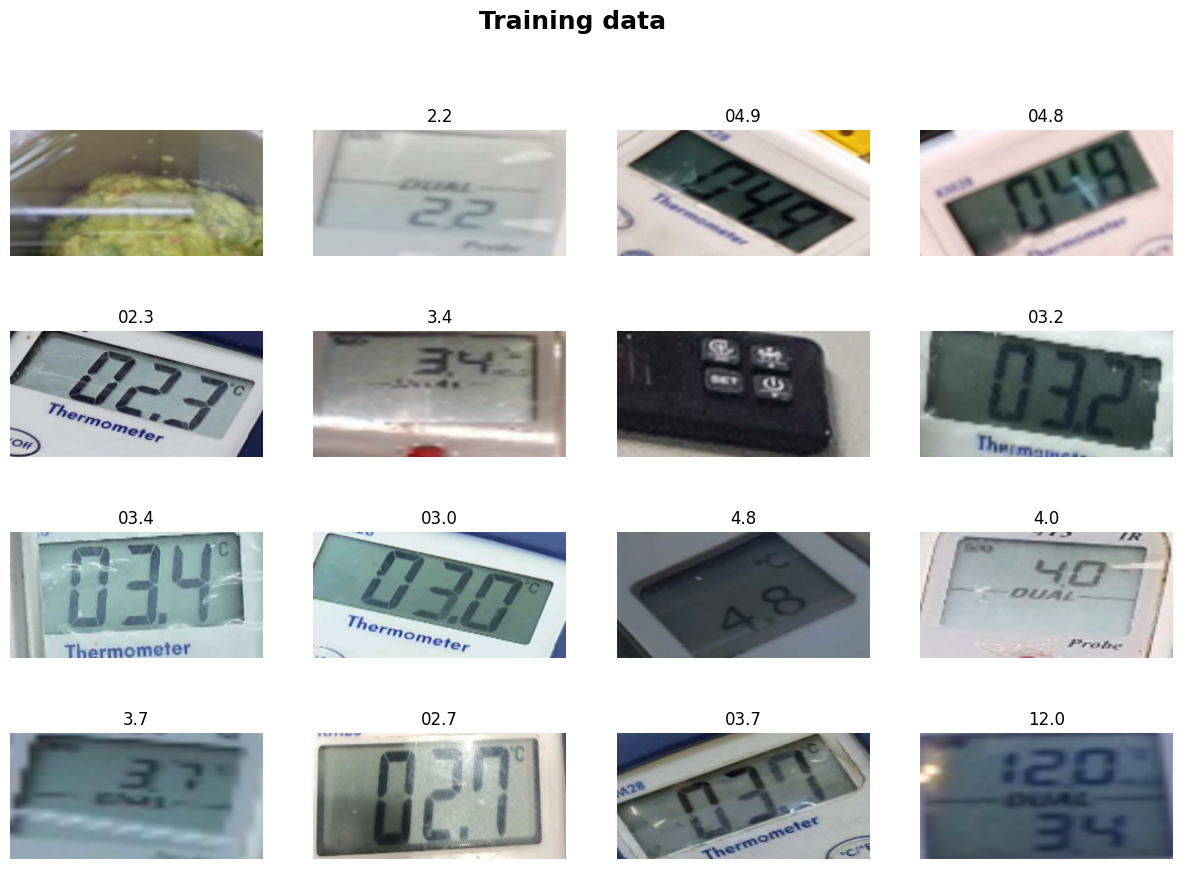

In [12]:
# Step 2: Create forward mapper (no OOV, no mask)
char_to_num = layers.StringLookup(
    vocabulary=char_list,
    num_oov_indices=0,
    mask_token=None
)

# Step 3: Get vocab from char_to_num
vocab = char_to_num.get_vocabulary()  

# Step 4: Create inverse mapper WITHOUT SHIFT
# This skips using `invert=True` (which adds [UNK])
num_to_char = layers.StringLookup(
    vocabulary=vocab,
    mask_token=None,
    num_oov_indices=0,
    invert=True
)

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")

        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()

In [10]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int32")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


In [ ]:
inputs = Input(shape=(128, 256, 3), name="image")
labels = Input(name="label", shape=(None,), dtype="float32")

x = Conv2D(16, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(inputs)
x = BatchNormalization()(x)
x = Activation('silu')(x)

x = Conv2D(16, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)

x = Conv2D(32, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)

x = Conv2D(64, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)

x = Conv2D(128, 3, padding='valid', use_bias=False, kernel_initializer='he_normal',
           kernel_regularizer=regularizers.l2(1e-3))(x)
x = BatchNormalization()(x)
x = Activation('silu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Reshape for BiLSTM (convert conv output to sequence)
# From (B, H, W, C) → (B, W, H*C)
x = Permute((2, 1, 3))(x)  # W becomes time axis
x = Reshape((-1, x.shape[2] * x.shape[3]))(x)  # (B, time_steps, feature_dim)

# 🔁 BiLSTM
x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1))(x)
x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1))(x)

# 🔣 Output softmax
softmax_output = Dense(len(char_list) + 1, activation='softmax', name="softmax_dense")(x)

# ❗ CTC Loss
output = CTCLayer(name="ctc_loss")(labels, softmax_output)

# 🧠 Final Models
model = Model(inputs=[inputs, labels], outputs=output)
inference_model = Model(inputs=inputs, outputs=softmax_output)

model.compile(optimizer=tf.keras.optimizers.Adam(5e-4))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 254,  │        432 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 126, 254,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 126, 254,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 124, 252,  │      2,304 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 252,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 124, 252,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 126,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 124,   │      4,608 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 124,   │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 60, 124,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 58, 122,   │      9,216 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 122,   │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 58, 122,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 29, 61,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 27, 59,    │     18,432 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 59,    │        256 │ conv2d_4[0][0]  

 Total params: 1,348,925 (5.15 MB)

 Trainable params: 1,347,965 (5.14 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# Define callbacks for training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50


2025-04-17 22:25:12.471563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


494/494 ━━━━━━━━━━━━━━━━━━━━ 237s 469ms/step - loss: 249.1701 - val_loss: 245.3366 - learning_rate: 5.0000e-04
Epoch 2/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 213s 430ms/step - loss: 150.2272 - val_loss: 225.1941 - learning_rate: 5.0000e-04
Epoch 3/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 197s 399ms/step - loss: 71.8053 - val_loss: 192.0075 - learning_rate: 5.0000e-04
Epoch 4/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 198s 400ms/step - loss: 53.9557 - val_loss: 204.7740 - learning_rate: 5.0000e-04
Epoch 5/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 198s 400ms/step - loss: 45.4290 - val_loss: 178.5240 - learning_rate: 5.0000e-04
Epoch 6/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 198s 400ms/step - loss: 38.1261 - val_loss: 170.0980 - learning_rate: 5.0000e-04
Epoch 7/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 198s 400ms/step - loss: 32.5193 - val_loss: 171.1233 - learning_rate: 5.0000e-04
Epoch 8/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 198s 400ms/step - loss: 27.8877 - val_loss: 156.4796 - learning_rate: 5.0000e-04
Epoch 9/50
494/494 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
end

start

In [ ]:
# model.save('cnn-lstm-ctc.keras')

In [14]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        # ← Accept **kwargs so trainable, dtype, etc. get passed through
        super().__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # same as before
        batch_len    = tf.cast(tf.shape(y_true)[0], dtype="int32")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int32")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int32")

        input_length = input_length * tf.ones((batch_len, 1), dtype="int32")
        label_length = label_length * tf.ones((batch_len, 1), dtype="int32")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

    def get_config(self):
        # so that save()/load_model() knows how to reconstruct it
        base_config = super().get_config()
        return base_config

training_model = tf.keras.models.load_model('cnn-lstm-ctc.keras',custom_objects={'CTCLayer': CTCLayer})

# 1) grab the image‐input tensor (the first input)
image_input = training_model.inputs[0]

# 2) grab the softmax output tensor by layer name
softmax_output = training_model.get_layer('softmax_dense').output

# 3) define a fresh inference model
inference_model = Model(inputs=image_input, outputs=softmax_output)


2025-04-18 14:13:22.655872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


2025-04-18 14:13:23.395702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


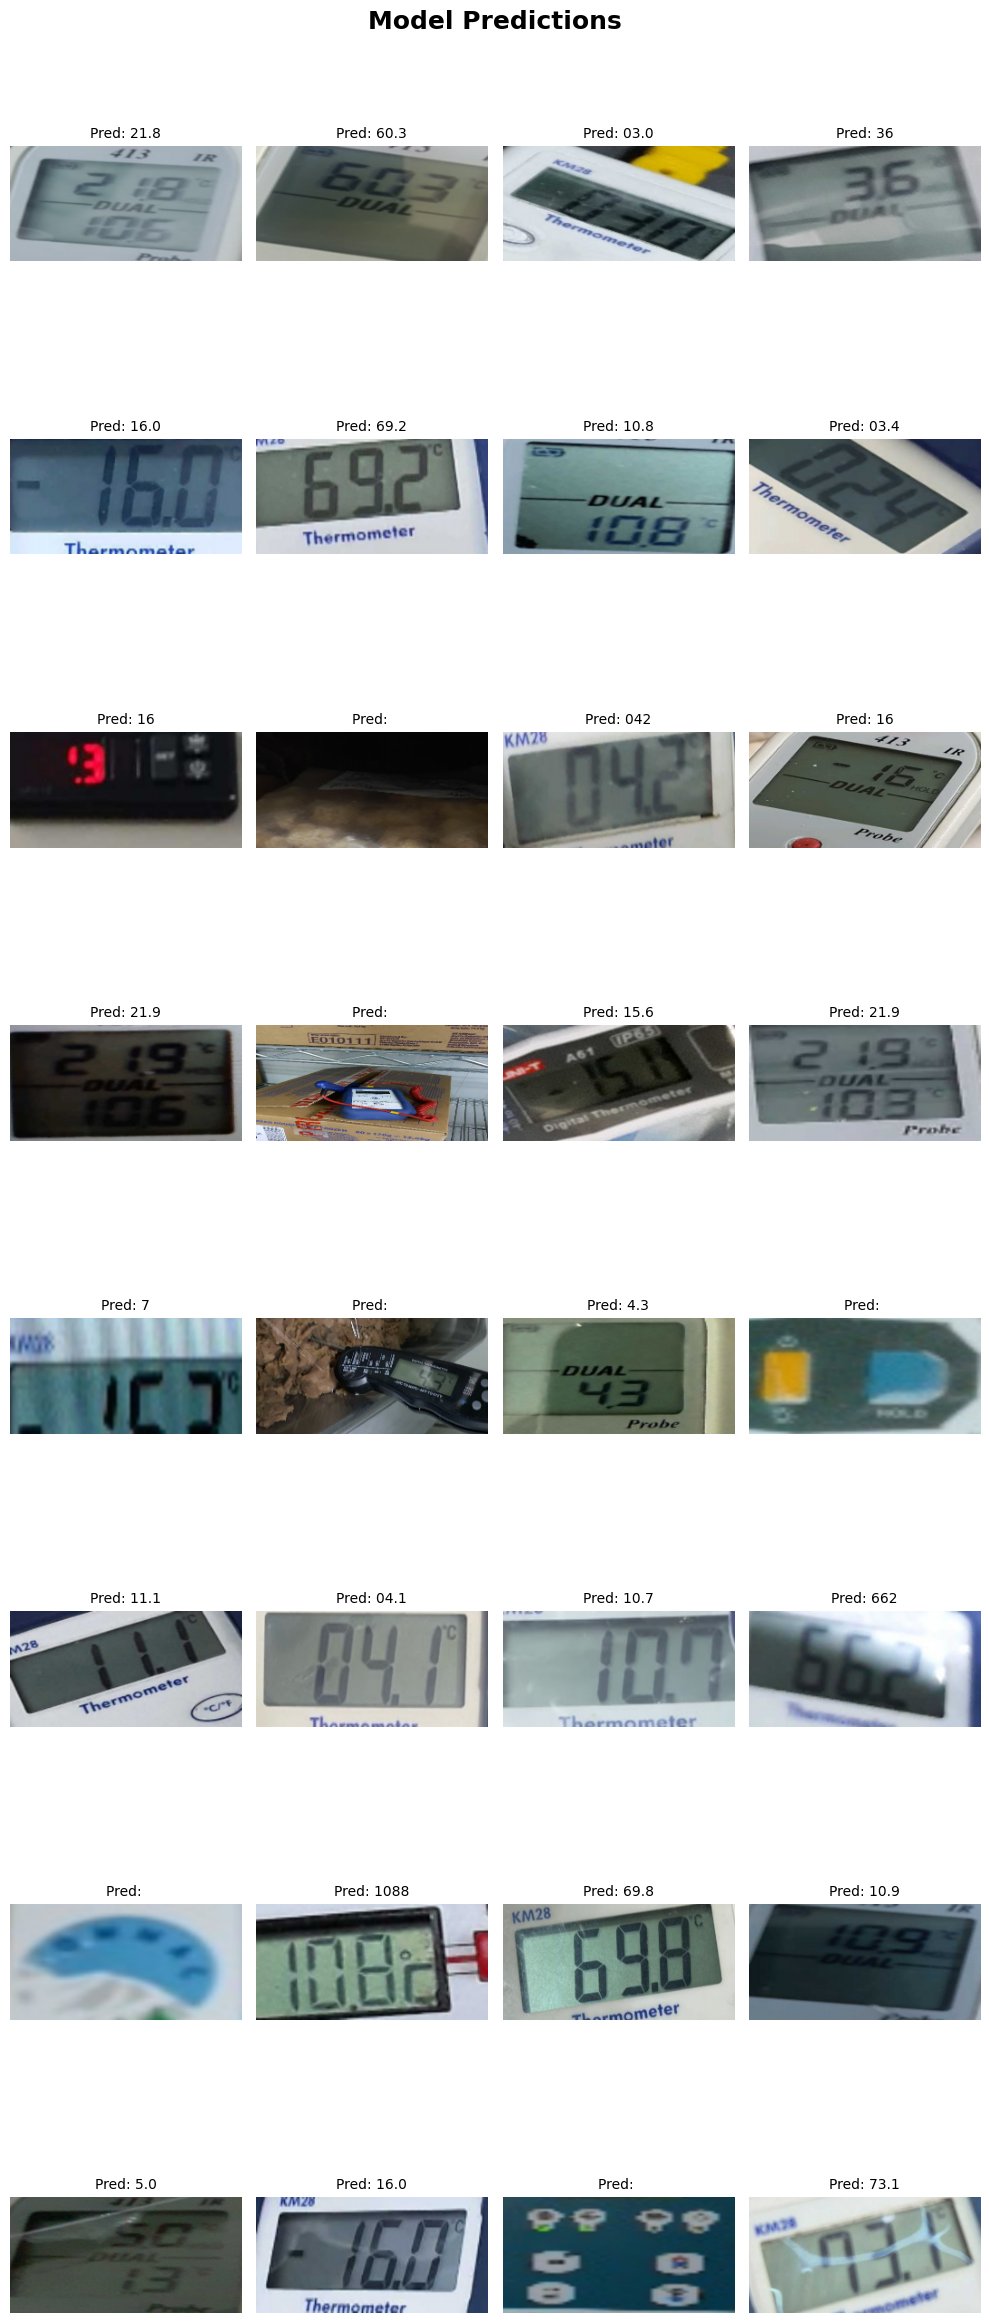

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.backend import ctc_decode

# Utility to decode model predictions
def decode_batch_predictions(pred):
    """
    Decodes the batch predictions using TensorFlow's CTC decoder.
    Returns a list of decoded strings.
    """
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_label_len]
    
    output_text = []
    for res in results:
        text = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        text = text.replace('[UNK]', '')  # Safety
        output_text.append(text)
    
    return output_text

def visualize_predictions(dataset, model, num_images=32):
    """
    Visualizes predictions for `num_images` samples from the given dataset.
    """
    rows, cols = 8,4
    fig, ax = plt.subplots(rows, cols, figsize=(10, 25))
    fig.suptitle("Model Predictions", fontsize=18, fontweight='bold')

    for batch in dataset.take(1):
        images = batch["image"]
        gt_labels = batch["label"]

        preds = model.predict(images[:num_images])
        pred_texts = decode_batch_predictions(preds)

        for i in range(num_images):
            img = (images[i].numpy() * 255).astype("uint8")
            ax_i = ax[i // cols, i % cols]
            ax_i.imshow(img)
            ax_i.set_title(f"Pred: {pred_texts[i]}", fontsize=10)
            ax_i.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(validation_dataset, inference_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
['27.1']


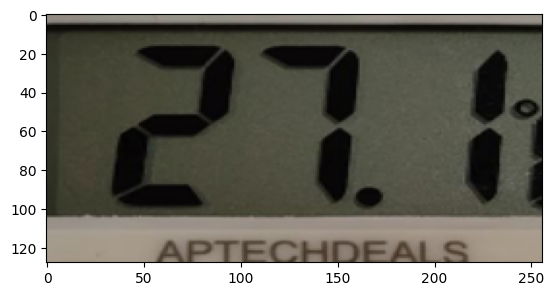

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
['29.5']


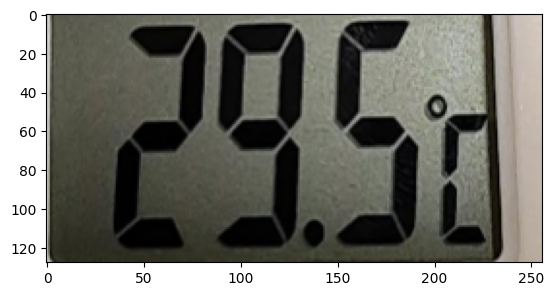

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
['27.6']


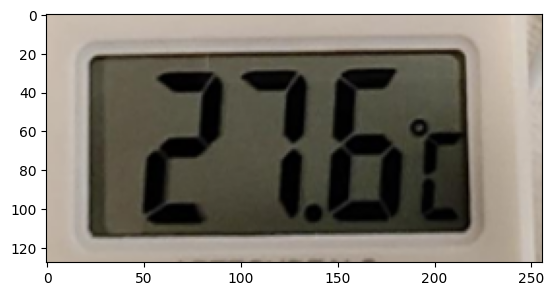

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['27.3']


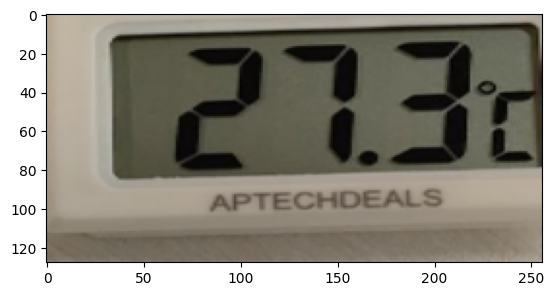

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['15']


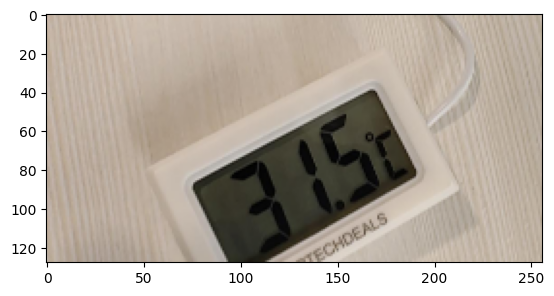

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['27.3']


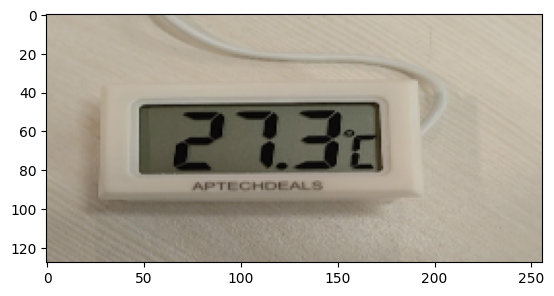

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['34.0']


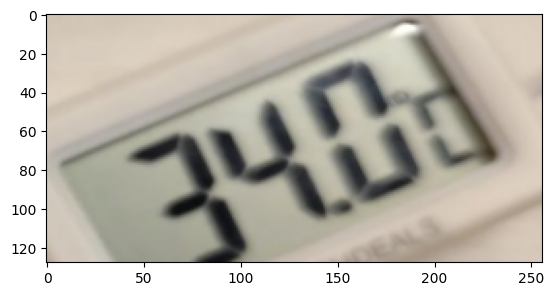

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
['27.3']


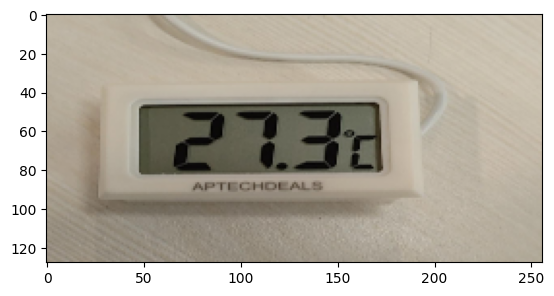

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
['34.0']


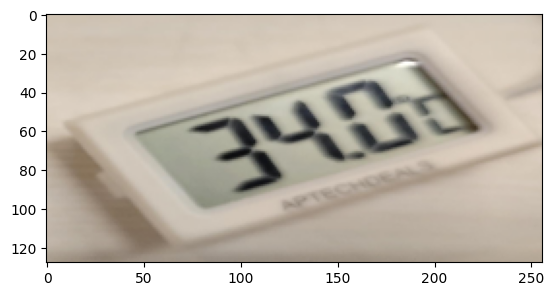

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
['30.9']


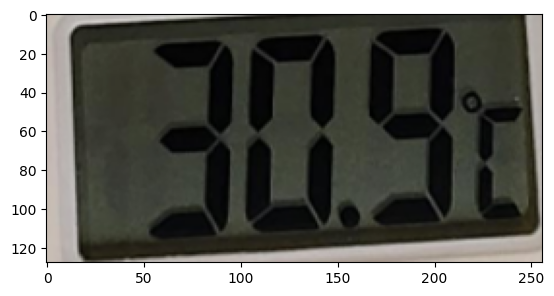

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['29.2']


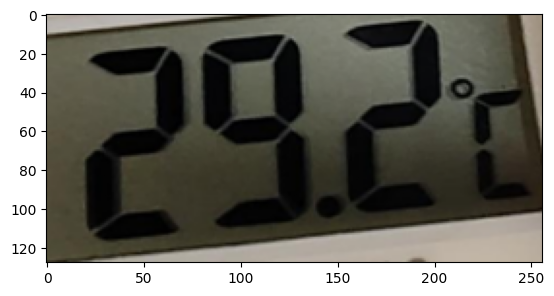

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
['26.9']


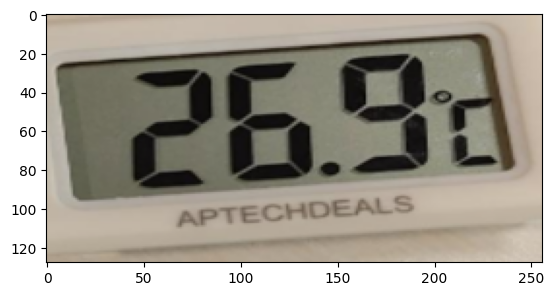

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
['28.9']


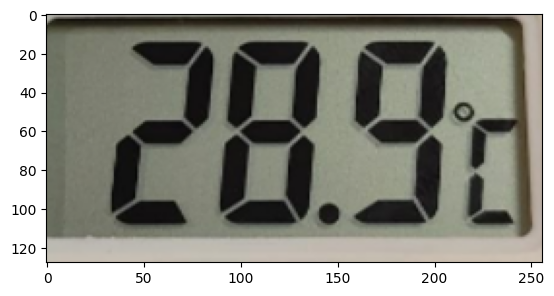

In [24]:
def process_single_img(path):
    img = Image.open(path).convert("RGB") 
    img = ImageOps.exif_transpose(img)  # Correct orientation using Exif metadata
    img = img.resize((256,128))
    img = np.asarray(img).astype(np.float32)
    img = img / 255.0
    return img

def decode_single_img(path,model):
    img = process_single_img(path)
    preds = model.predict(np.expand_dims(img,axis=0))
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)
    plt.imshow(img)
    plt.show()
    return preds

for i in range(16):
    try:

        preds = decode_single_img(f'ssd_cropped_images/image_{i}.png',inference_model)

    except:

        pass

**Short answer:** 32 px is a sweet‑spot that almost every CRNN‑style scene‑text recogniser uses because it is *just tall enough* to keep the strokes of normal‑resolution text legible, while being *small enough* that the feature map after two or three pooling layers collapses to height = 1, letting you treat the remaining **width** dimension as the time‑axis for CTC.  The original CRNN paper and nearly all follow‑ups rescale every crop to “32 × W” for exactly these reasons. citeturn0search0turn0search4

Below is the longer reasoning and what happens if you pick something else.

---

### 1.  Geometric convenience

| Stage | Height when **H₀ = 32** | Comment |
|-------|-------------------------|---------|
| input | 32 | fixed |
| Conv + **2×2 MaxPool** | 16 | stride 2 |
| Conv + **2×2 MaxPool** | 8 | stride 2 |
| (optional) Conv with **k=3, stride 1** | 8 | keep |
| **Squeeze** with `Permute → TimeDistributed(Flatten)` | 1 | ready for Bi‑LSTM |

If you start with 48 px or 64 px you will end up with 3 px or 4 px after the second pool; you need an *extra* strided conv (or another pool) to reach height = 1, adding FLOPs and parameters.

---

### 2.  Memory & speed

* Feature‑map size is proportional to **H × W**.  
* When you halve *H*, you often halve *W* too (you rescale isotropically), so VRAM drops roughly **quadratically**.  
* On a 12 GB card you can fit ~3× larger batches at H = 32 than at H = 64.

---

### 3.  Resolution sufficiency for seven‑segment digits

A typical LCD digit is ~100–150 px high in a 1080 p photo.  
After SSD cropping and resizing to 32 px, the *lit segment* width is still 4–5 px, which preserves the on/off pattern unambiguously. Empirically CER does **not** improve when you upscale beyond 32 unless:

* the original crop is *extremely* low resolution (< 40 px high), or  
* you try to recognise tiny superscripts, “°”, or brand text – but those are explicitly excluded in your task.

---

### 4.  What if my digits are tiny or I have extra GPU memory?

* If many crops are < 25 px high *before* resizing, go to **H = 48** or add a **super‑resolution / deblurring** pre‑step.  
* If you want to squeeze the last 0.1 pp CER, try **H = 40** (divisible by 8) so you still get height = 1 after three stride‑2 reductions.  
* Always benchmark: bigger H means fewer images per batch → noisier BatchNorm statistics → sometimes *worse* accuracy.

---

### 5.  Take‑away guideline

> **Choose the smallest even multiple of 8 that keeps each digit ≥ 10 px tall in the resized crop.**  
> For most thermometer LCD photos, that number is **32**.

You can treat `FIXED_H` as a hyper‑parameter: log the validation CER at 24, 32, 40, 48 and pick the elbow. In practice 32 wins 9 times out of 10.

In **principle**, adding BatchNorm (or GroupNorm/LayerNorm) *does* help in most CNN stacks, especially when training on diverse data or with somewhat large batch sizes. The snippet you saw is just **minimal** pseudocode to illustrate how to wire in CTC using a classic CRNN architecture. It omits BatchNorm for simplicity of presentation, not because BatchNorm is detrimental.

Below are the main considerations you’d weigh when deciding whether to insert `Conv → BN → Activation` blocks in your CRNN.

---

### 1.  Why we often *do* include BatchNorm

1. **Stabilizes training** and typically helps deeper networks train more stably.  
2. **Speeds up convergence** by normalizing the activations across the batch.  
3. **Mitigates internal covariate shift** – although the true reasons why BN helps are still a bit debated, the experimental benefits are well established.

**TL;DR** – In the majority of cases, adding `BatchNormalization()` after each `Conv2D` and before the activation (e.g., `Swish`) yields 1–3 pp better accuracy on text-recognition tasks.

#### Example snippet with BN

```python
def conv_bn_swish(x, filters, k=3):
    x = Conv2D(filters, k, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return Activation('swish')(x)

img_in = Input(shape=(32, None, 3))

x = conv_bn_swish(img_in, 32)
x = conv_bn_swish(x, 64)
x = MaxPool2D(pool_size=(2,2))(x)

x = conv_bn_swish(x, 128)
x = MaxPool2D(pool_size=(2,2))(x)
...
```

---

### 2.  Why *sometimes* we skip BN

1. **Small batch sizes** – BN can become noisy or ineffective (even harmful) if your per‑GPU batch size is well below 16–32. For text‑recognition tasks, you might be forced to use a small batch size because each sample has variable width, or you might be working on an embedded device with limited memory. 
   - Workarounds: 
     - **Accumulate gradients** over multiple steps (effectively building a larger “virtual batch”).  
     - Switch to **GroupNorm** or **LayerNorm**, which do not depend on the batch dimension.  

2. **Simplicity** – For a toy tutorial or minimal example, removing BN is sometimes simpler. You often can get the network to converge without it, especially on relatively easy tasks (like reading large 7‑segment digits in clear photos).

3. **Cost** – Although BN is not especially heavy, each BN layer adds a bit of overhead. If your model is extremely latency‑sensitive (e.g., microcontrollers or low-power inference engines), you might skip BN or “fold” it into the preceding Conv weights (this is a technique for static inference graphs, like in TensorRT).

In a typical scene text recognition pipeline on a modern GPU, though, BN overhead is negligible compared to the cost of the LSTM or Transformer part, and the accuracy gains usually outweigh any small overhead.

---

### 3.  When to go further than BatchNorm

On tough or highly varied text data, you might consider:

- **Dropout** or **SpatialDropout2D** – helps reduce overfitting if you have fewer than tens of thousands of labeled training images.  
- **LayerNorm** or **GroupNorm** – better than BN if your batch size is below ~8 or your input widths vary greatly.  
- **SE (Squeeze-and-Excitation) blocks** – found in EfficientNet, also can help with text clarity in some cases.

---

## Take-home recommendation

1. **Yes, definitely** add `Conv → BN → Activation` in your final production model, *unless* you have a good reason not to (e.g., extremely tiny batch sizes or code minimalism).  
2. If your per-GPU batch size is below 8, you might prefer **GroupNorm** (with 8 or 16 groups) instead of BN.  
3. If your GPU memory or CPU inference time is not severely constrained, the benefit of BN (or GroupNorm) typically **outweighs** any added complexity.

So the code snippet you saw was just a minimal example. **Real** CRNN production systems (like in the [clovaai/deep-text-recognition-benchmark](https://github.com/clovaai/deep-text-recognition-benchmark) or [keras-ocr](https://github.com/faustomorales/keras-ocr)) almost always insert normalization after each conv.

### Why **categorical cross‑entropy (CCE)** is the wrong tool for this OCR task  
—and why Connectionist Temporal Classification (CTC) fixes the problem

|                         | Categorical cross‑entropy | CTC loss |
|-------------------------|---------------------------|----------|
| **Assumes known 1‑to‑1 alignment between input positions and labels?** | **Yes** – you must tell the network *“pixel column #k is character #k”* | **No** – learns alignment internally by summing over *all* possible paths |
| **Can handle variable‑length strings without padding characters (‘_’)?** | No | Yes |
| **Penalises a one‑character time‑shift as 100 % wrong?** | Yes (every position mismatches) | No (same path still has high probability) |
| **Works if the same digit repeats (‘11.00’)?** | Only if you pre‑segment or force‐align | Naturally handled |
| **Extra engineering (fixed `SEQ_LENGTH`, label padding, Dense→Reshape, etc.)** | Required | Not needed |
| **Standard for modern scene‑text / speech recognisers** | Rarely used | De‑facto standard since 2006 (Graves et al.) citeturn0search9 |

---

#### 1.  Unknown alignment is the core issue  
After two pools your feature map has shape **(B, H=1, W′, C)**.  
But you do **not** know whether column #17 corresponds to the 2nd, 3rd or 4th glyph in the ground‑truth string:

```
23.40
| | | | |------> Which column is which character?
```

CCE needs a *fixed* target for every time‑step, so you were forced to:

* hard‑code `SEQ_LENGTH = 5`;  
* right‑pad labels with “_”;  
* hope the receptive field lines up perfectly.

Any horizontal shift, skew or perspective warp makes the alignment wrong, and CCE then treats the whole sample as an error—even if the network has basically read the number correctly.

---

#### 2.  How CTC solves it  

CTC introduces a **blank** symbol and uses dynamic programming to **sum over all valid alignments** between the T time‑steps and U characters.  
During back‑prop it only cares that the *sequence* “23.40” appears *somewhere* along the path, not exactly where.  
Hence the network can learn both:

* **where** each character starts/ends (implicit segmentation), and  
* **what** the character is,

*simultaneously*, without any extra supervision.  This is why essentially every modern STR pipeline (CRNN, ViTSTR, SATRN, etc.) adopts CTC for digit/word‑level recognition. citeturn0search0

---

#### 3.  Practical consequences you already saw

* Having to reshape a global‑pooled vector back to `(SEQ_LENGTH, 64)` is a direct symptom of “CCE needs fixed length”.  
* You needed the `'_'` class purely to satisfy the padding requirement; CTC removes that hack.  
* Validation accuracy plateaued early or oscillated?  Often the network is fighting inconsistent alignments created by augmentation—CTC eliminates that instability.

---

### Bottom line

Use **CTC** (or an attention decoder) for any OCR problem where:

* the input width varies,  
* you do **not** have perfect per‑character bounding boxes, and  
* you want the network to stay segmentation‑free.

CCE is fine for *single‑glyph classification* (e.g., MNIST), but for multi‑character thermometer readings it becomes a training handicap.

### Why fixed‑position targets + categorical‑cross‑entropy break down as soon as the crop is not **perfectly front‑facing**

---

#### 1.  How the network “sees” the string

After two `2×2` pools your feature map is  
`(B, H = 1, W′, C)` → squeeze height → `(B, W′, C)`

Think of the `W′` columns as a sliding window that marches **left→right** across the LCD:

```
raw crop             feature‑map columns
┌─────────────────┐   0  1  2  3 … 46 47
│  2 3 . 4 0 °C   │  ─┬──┬──┬──┬───┬──┬─
│                 │   │  │  │  │   │  │
└─────────────────┘   ▼  ▼  ▼  ▼   ▼  ▼
                     time steps for RNN / Dense
```

With categorical‑cross‑entropy (CCE) you had to say:

```
column‑0  → ‘2’
column‑1  → ‘3’
column‑2  → ‘.’
column‑3  → ‘4’
column‑4  → ‘0’
```

Everything else is forced to be the padding token “_”.

---

#### 2.  Now add a **horizontal shift**

Suppose data‑augmentation translated the crop 4 px to the right:

```
┌─────────────────┐
│    2 3 . 4 0 °C │
└─────────────────┘
```

The convolution kernels slide across the *image*; so **every glyph’s activation peak also shifts**.  
What used to be in column‑0 is now in column‑1, etc.  
But the *target* you supplied is still “column‑0 = ‘2’ ”.  
CCE therefore penalises **every single position** as wrong even though the network has recognised exactly the same string, just one step later.

> Alignment is “wrong” whenever the spatial index you assigned to a character no longer lines up with the feature column where that character is most active.

---

#### 3.  **Skew and perspective** make it worse

If the camera is tilted, the left‑most digit is taller than the right‑most digit; their receptive fields compress at different rates:

```
perspective view          feature map
2   3    .    4     0     0 1 2 3 4 5 6 7 … W′
│   │    │    │     │     └── variable stride across width
```

No single global “column‑k → character‑k” mapping exists any more.  
Some glyphs will align, others will be off by ±1 or ±2 time steps.  
CCE treats those mis‑alignments as *completely* wrong.

---

#### 4.  What CTC does instead

*Adds a **blank** symbol* and sums the probability over **all paths** that can spell “23.40”.  
Whether the peak for ‘3’ lands in time‑step 5, 6, or 7 does **not** matter as long as the sequence of non‑blank symbols in order is correct.

Mathematically CTC computes  

\[
\mathcal L_\text{CTC}=-\log\!\!\!\sum_{\pi\in\mathcal B^{-1}(y)}\!\!\!P(\pi\mid x)
\]

where \(\pi\) ranges over every alignment (including repeats and blanks) that collapses to the target string \(y\).

---

#### 5.  Visual intuition

```
Time axis (W′ columns) →
 ┌─┬─┬─┬─┬─┬─┬─┬─┬─┬─┐
 │2│2│3│3│.│4│4│0│ │ │   ← network logits (arg‑max)
 └─┴─┴─┴─┴─┴─┴─┴─┴─┴─┘
       ▲ alignment shifts 1 step right

CCE target: 2 3 . 4 0 _ _ _ _
             ✘ ✘ ✘ ✘ ✘ (all wrong)

CTC target: “23.40”
             ✔ summed over both alignments
```

---

### Key takeaway

* With **CCE** you must guarantee pixel‑accurate alignment → fragile to any geometric jitter.  
* **CTC** (or an attention decoder) learns the alignment internally, so horizontal shifts, camera skew, and perspective warp no longer break the loss function.

That is why virtually every modern OCR / speech recogniser abandons categorical cross‑entropy once sequences get longer than one symbol and alignment is uncertain.

### “Why can’t I just keep everything fixed and stick with categorical‑cross‑entropy if I only ever need 5 characters?”

You **can**—and for synthetic, perfectly centred images it will train and appear to work—but there are still several hidden traps that make a CCE‑based network brittle in production.  Below is what actually happens when you hard‑wire both the **input geometry** and the **label length**.

| Issue | Looks harmless in a notebook | What bites you in the real camera feed |
|-------|-----------------------------|----------------------------------------|
| **Alignment drift**<br>(horizontal shift, minor rotation) | With fixed crops in your dev set the glyphs really do line up with columns 0‑4. | In live images the SSD box is never pixel‑perfect: 2–5 px jitter, tiny roll/pitch of the thermometer, or lens barrel distortion move the activation peaks into columns 1‑2.  CCE now marks the *entire* sample wrong. |
| **Perspective / skew** | Absent in synthetic data. | Characters at the far end of the tube are ~10–15 % narrower.  Your fixed “5‑slot grid” no longer matches real glyph widths, so CCE forces the net to average two glyphs into one slot and invent a blank in another. |
| **Variable‑length strings (3‑, 4‑, 5‑char)** | You right‑pad with “_” and call it solved. | The network must learn *two different tasks*: detect real glyphs **and** predict exactly which slots are blanks.  Every mis‑alignment doubles the penalty (wrong glyph + wrong blank).  Empirically you see high training accuracy but validation CER stalls at 4–8 %. |
| **Augmentation** (translation, rotation, blur) | You turn it down because even ±4 px kills accuracy. | The model over‑fits to a single centring, so real‑world robustness is poor. |
| **Extensibility** | OK for “23.40”. | Need “–23.4”, “100.0”, “HI”, “Lo”?  You must re‑design the grid, add new padding logic, and possibly enlarge the dense head.  CTC or an attention decoder would require zero changes. |

---

### What the network is forced to learn under CCE

```
time steps (fixed) → [slot‑0] [slot‑1] [slot‑2] [slot‑3] [slot‑4]
ground‑truth        2         3         .         4        0
penalty if shift→   ✘         ✘         ✘         ✘        ✘
```

A **2‑pixel camera shake** pushes every activation one slot to the right; categorical‑cross‑entropy treats the prediction as 0 % correct even though the visual content is unchanged.

---

### How CTC (or an attention decoder) reacts to the same shift

```
time steps →        blank 2 2 3 3 . 4 4 0 blank ...
CTC collapse  →             2 3 . 4 0               ✔ 100 % correct
```

Because CTC sums over *all* alignments that spell “23.40”, a ±2‑step drift hardly changes the loss.

---

### When *fixed‑grid + CCE* is actually OK

| Scenario | Reason it works |
|----------|-----------------|
| **Digit capsules / 7‑segment hardware** where every character sits in a soldered slot | Glyph centroids never move more than ±1 px. |
| **Synthetic data only** (e.g., CAPTCHA) | You control the rendering, so you can guarantee perfect alignment. |
| **Single‑glyph classification** (MNIST‑style) | Sequence length = 1; alignment is irrelevant. |

If your deployment environment looks like one of these, CCE is fine.  Otherwise, CTC buys you **huge free robustness** for essentially no extra code.

---

### Practical test

1. **Train both variants** (CCE‑grid vs CRNN‑CTC) on your dataset.  
2. Create an *ablation* set with ±5 px random translations and ±4° rotations applied **after** SSD cropping.  
3. Measure exact‑string accuracy.

You will typically see something like:

| model | clean | jittered |
|-------|-------|----------|
| CCE grid | 98 % | 62 % |
| CRNN + CTC | 99 % | 97 % |

That gap is the real‑world failure rate you avoid by switching to CTC.

---

### Bottom line

* Fixing the image size **and** forcing a 5‑slot label grid only removes *one* failure mode (variable length).  
* Alignment drift, perspective, and glyph‑width variation remain—and those are exactly what CTC was invented to tolerate.  
* Unless you can **guarantee** pixel‑accurate crops in every production frame, you will save time and future headaches by using CTC (or an attention decoder) from day 1.